In [10]:
import pandas as pd
import os

lista_personaggi = ['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']

folder_path = 'C:/Users/sollillo1/pythonProjects/fondamenti/Progetto_9/lfw_funneled/'

#definiamo una funzione per creare un DataFrame che fornisca dati sul sottoinsieme di interesse
def filter(file):
    file_name = os.path.join(folder_path, file)
    data = []

    try:
        with open(file_name, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    try:
                        personaggio, image_name = line.split('/')
                        if personaggio in lista_personaggi:
                            data.append([personaggio, image_name])
                    except ValueError:
                        print(f"Linea malformata in {file}:{line}")
    except FileNotFoundError:
        print(f"File non trovato: {file_name}")
    
    return pd.DataFrame(data, columns = ['Personaggio', 'Nome_immagine'])

#Consideriamo solo i file .txt che contengono informazioni sui personaggi del nostro sottoinsieme
files = ['pairs_01.txt', 'pairs_02.txt', 'pairs_03.txt', 'pairs_04.txt','pairs_05.txt','pairs_06.txt', 'pairs_07.txt','pairs_08.txt', 'pairs_09.txt', 'pairs_10.txt']

#Inseriamo i dati rilevanti ricavati da ciascun file in un unico dataframe
df_unico = pd.concat([filter(file) for file in files], ignore_index = True)

#Eliminiamo elementi duplicati 
df_unico.drop_duplicates(['Personaggio', 'Nome_immagine'], inplace=True)
#display(df_unico)

foto_pers = df_unico['Personaggio'].value_counts()

In [11]:
import numpy as np                
from matplotlib.image import imread 
import matplotlib.pyplot as plt
import cv2

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_face(gray_img):
    #rilevo i volti (l'immagine è già in scala di grigi)
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        #se nessun volto è rilevato, ritorna None
        return None
    
    #prendo il primo volto rilevato
    (x, y, w, h) = faces[0]
    cropped_face = gray_img[y:y+h, x:x+w]
    
    return cropped_face

subset_foto = []
#etichette per addestrare il modello 
personaggi_labels = []
nfaces_dict = {}

for personaggio in lista_personaggi:
    nfaces_dict[personaggio] = 0

for nome_cartella in os.listdir(folder_path): 
    percorso_cartella = os.path.join(folder_path, nome_cartella) #creiamo  il percorso completo alla cartella

    #ci accertiamo di accedere solo alle cartelle dei personaggi di interesse
    if os.path.isdir(percorso_cartella) and nome_cartella in lista_personaggi:
        #iteriamo attraverso le foto della cartella
        for file_name in os.listdir(percorso_cartella):
            file_path = os.path.join(percorso_cartella, file_name)
            #verifichiamo che il file a cui cerchiamo di accedere sia un'immagine e che non sia un duplicato
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                #utilizziamo imread per leggere l'immagine e caricarla in un array
                img = imread(file_path)
                #riduciamo le immagini a colori in scala di grigi calcolando la media dei valori della dimensione contenete i canali di colore
                #   print("Dimensione immagine a colori:", img.shape)
                img = np.mean(img , -1).astype(np.uint8)
                #   print("Dimensione immagine in scala di grigi:", img.shape)
                
                cropped_face = detect_and_crop_face(img)
                if cropped_face is not None:
                    #le immagini ritagliate possono avere diverse dimensoni 
                    resized_face =cv2.resize(cropped_face, (250,250))
                    #trasformo l'array multidimensionale dell'immagine appena aperta in un array unidimensionale
                    flattened_img = resized_face.flatten()
                    #   print("Dimensione appiattita:", flattened_img.shape)
                    subset_foto.append(flattened_img) 
                    personaggi_labels.append(nome_cartella)
                    nfaces_dict[nome_cartella] +=1


nfaces = []           
for personaggio in lista_personaggi:
    nfaces.append(nfaces_dict.get(personaggio, 0))

print("nfaces:", nfaces)
  
# X è la matrice di tutte le immagini appiattite, (250*250, N_immagini), ogni colonna rappresenta un'immagine
X = np.array(subset_foto).T
print(f"Dimensioni matrice di tutte le foto: {X.shape}")

nfaces: [77, 235, 121, 529, 109, 71, 144]
Dimensioni matrice di tutte le foto: (62500, 1286)


Dimensione vettore unidimensionale volto medio: (62500,)


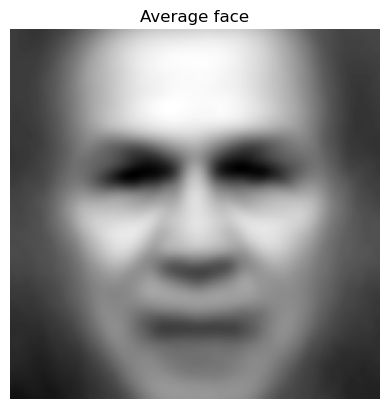

In [12]:
#calcoliamo il volto medio per centrare i dati
fig1 = plt.figure()
avgFace = np.mean(X, axis = 1)
print(f"Dimensione vettore unidimensionale volto medio: {avgFace.shape}")

img_avg = plt.imshow(np.reshape(avgFace, (250,250)))
img_avg.set_cmap('gray')
plt.axis('off')
plt.title('Average face')
plt.show()

In [13]:
X_centered = X - np.tile(avgFace, (X.shape[1], 1)).T
U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
print(f"Dimensioni matrice centrata:{X_centered.shape}")
print(f"Dimensioni matrici SVD: U:{U.shape}, S:{S.shape}, VT:{VT.shape}")

Dimensioni matrice centrata:(62500, 1286)
Dimensioni matrici SVD: U:(62500, 1286), S:(1286,), VT:(1286, 1286)


Dimensione matrice PCA 2 componenti principali:(2, 1286)


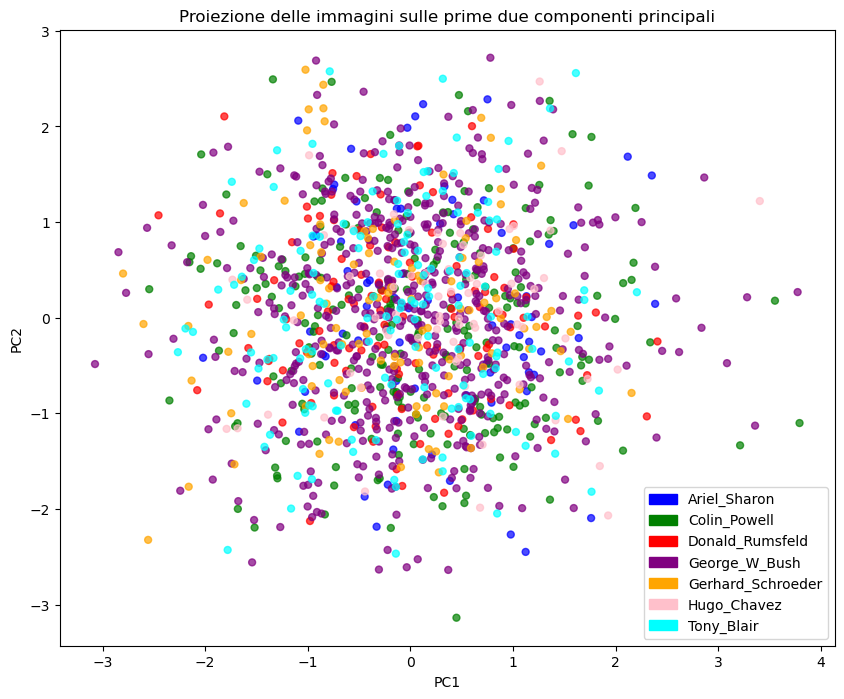

In [14]:
from sklearn.preprocessing import StandardScaler
PCAmodes = [0, 1] 
PCACoords = U[:, PCAmodes].T @ X_centered	
print(f"Dimensione matrice PCA 2 componenti principali:{PCACoords.shape}")

scaler = StandardScaler()
PCACoords_normalized = scaler.fit_transform(PCACoords.T).T

#creiamo un dizionario per assegnare alle immagini di ogni personaggio un colore distinto
colors = {
    'Ariel_Sharon': 'blue',
    'Colin_Powell': 'green',
    'Donald_Rumsfeld': 'red',
    'George_W_Bush': 'purple',
    'Gerhard_Schroeder': 'orange',
    'Hugo_Chavez': 'pink',
    'Tony_Blair': 'cyan'
}

#lista dei colori associati a ogni personaggio
point_colors = []
for label in personaggi_labels:
    point_colors.append(colors[label])

import matplotlib.patches as mpatches

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in colors.items()]

plt.figure(figsize=(10,8))
plt.scatter(PCACoords_normalized[0,:],PCACoords_normalized[1,:],color=point_colors, s=25, alpha=0.7)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proiezione delle immagini sulle prime due componenti principali')
plt.legend(handles=legend_patches)
plt.show()